In [12]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.linear_model import LinearRegression

In [7]:
# Read in College Data CSV
college_data = pd.read_csv('college-records.csv')

In [8]:
college_data.head()

,,Name,Public / Private,Annual Tuition (2023),Undergraduate Population (2023),Acceptance rate (2021),Ranking (top 100 or not),Geographic location,Male : Female (ratio),Type of College,...,2018,2019,2020,2021,2022,Bipartisan Slope,Bipartisan y-intercept,Ownership,County,School Size
0,region,name,publicprivate,tuition,population,acceptance,ranking,geo,male2female,college-type,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ownership,County,School Size
1,us-west,Stanford,Private,"$57,692","7,761",4.34%,6,Suburban,49 : 51,Research,...,-6.244466,-5.684776,-7.151565,-6.981125,-5.677183,-1.537808,NaN,Independent,Santa Clara,7645
2,us-west,UC Berkeley,Public,"$43,980","32,143",17.50%,49,Urban,46 : 54,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Alameda,"31,814"
3,us-west,Santa Clara,Private,"$58,017","5,895",52.00%,NaN,Suburban,53 : 47,Catholic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Santa Clara,5895
4,us-west,Caltech,Private,"$58,479",901,6.70%,2,Suburban,65 : 35,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Los Angeles,NaN


In [25]:
college_data.tail()

,,Name,Public / Private,Annual Tuition (2023),Undergraduate Population (2023),Acceptance rate (2021),Ranking (top 100 or not),Geographic location,Male : Female (ratio),Type of College,...,2018,2019,2020,2021,2022,Bipartisan Slope,Bipartisan y-intercept,Ownership,County,School Size
40,us-midwest,Kenyon,Private,"$63,310","1,662",36.50%,NaN,Rural,43 : 57,Research,...,3.012478,-2.512117,-3.643569,-3.592714,-2.955069,-0.473330,953.644406,independent,Knox,NaN
41,us-midwest,Illinois Wesleyan,Private,"$52,512","2,090",45.20%,NaN,Urban,49 : 51,Research,...,-5.978340,-0.772456,-0.115412,-0.591196,2.197966,NaN,NaN,independent,McLean,NaN
42,us-midwest,"University of Nevada, Reno",Public,"$24,680","20,194",88%,NaN,Rural,47 : 53,Research,...,-0.616725,-0.939728,-1.021639,-2.842037,1.678874,-0.365339,737.223329,independent,Washoe,NaN
43,us-midwest,Urbana-Champaign,Public,"$17,138","7,665",59.70%,NaN,Urban,54 : 46,Research,...,-1.879008,-1.528325,-3.371316,-2.642117,-4.669182,-0.261031,524.582127,independent,Champaign,NaN
44,us-midwest,University of Minnesota,Public,"$15,254","36,209",73.20%,NaN,Urban,45 : 55,Research,...,-2.840436,-2.218186,-3.918725,-2.057011,-1.747670,0.663542,-1343.133053,independent,Hennepin,NaN


In [30]:
election_data = pd.read_csv('election_data_12_20.csv')
election_data.head()

,county_name,per_dem_2012,per_gop_2012,per_dem_2016,per_gop_2016,per_dem_2020,per_gop_2020
0,Alaska,NaN,NaN,0.377159,0.52887,NaN,NaN
1,Alaska,NaN,NaN,0.377159,0.52887,NaN,NaN
2,Alaska,NaN,NaN,0.377159,0.52887,NaN,NaN
3,Alaska,NaN,NaN,0.377159,0.52887,NaN,NaN
4,Alaska,NaN,NaN,0.377159,0.52887,NaN,NaN


In [31]:
def get_county_info(county):
    fd = False
    for index, rows in election_data.iterrows():
        regex = re.escape(county) + r" .*"
        metrics_yr = None
        if re.match(regex, rows['county_name']):
            metrics_yr = [rows['per_gop_2012'] - rows['per_dem_2012'],rows['per_gop_2016'] - rows['per_dem_2016'],rows['per_gop_2020'] - rows['per_dem_2020']]
            fd = True
            break

    if fd:
        return metrics_yr
    else:
        print("County Not Found")
        return None

# Scaling

Not sure if I am scaling everything correctly so far. Need confirmation that the Bipartisan API spits out values from -42 to +42, or if it is from -1 to 1. Either way, we might need to check to see that we are doing this step correctly due to suspicious values in the csv file.

Santa Clara [-17.67275522842784, -22.047916401172426, -19.918250203992372]


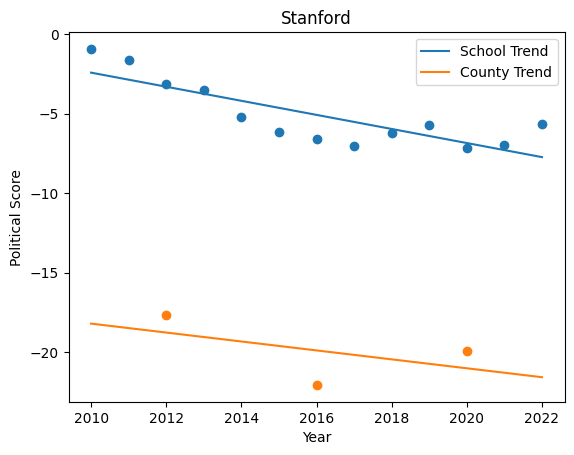

Alameda [-25.104429552316855, -27.066111106581108, -26.260092691696197]


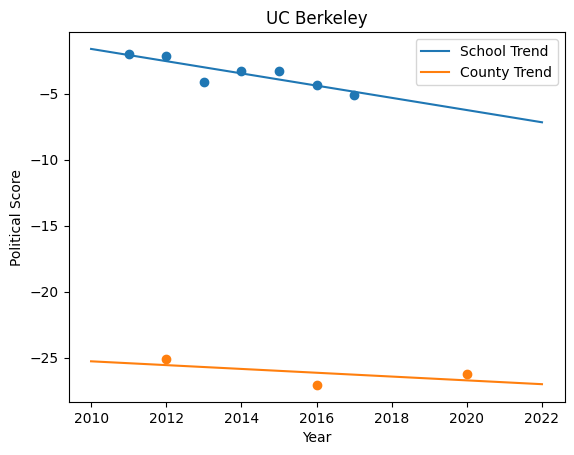

Los Angeles [-16.824502475215922, -20.167766938454164, -18.55329366429902]


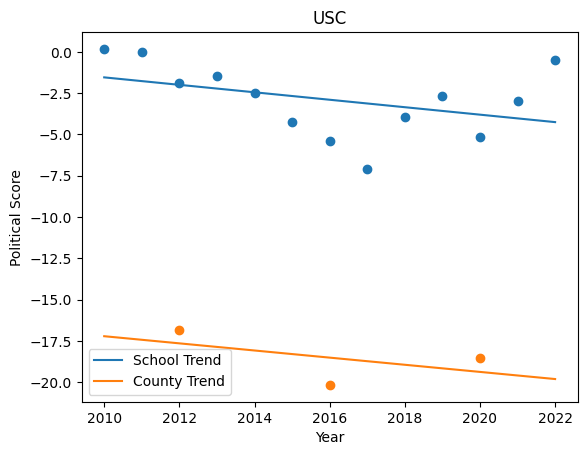

Los Angeles [-16.824502475215922, -20.167766938454164, -18.55329366429902]


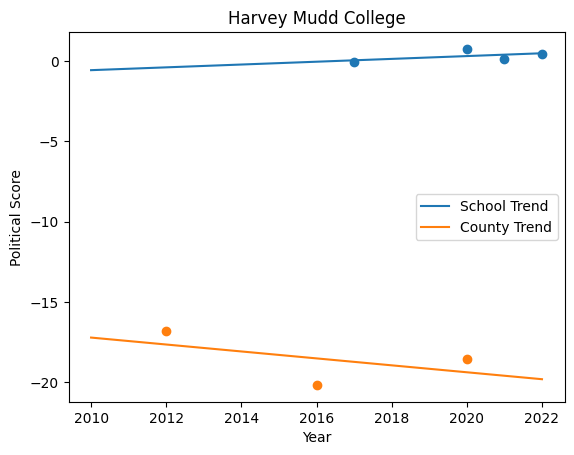

Los Angeles [-16.824502475215922, -20.167766938454164, -18.55329366429902]


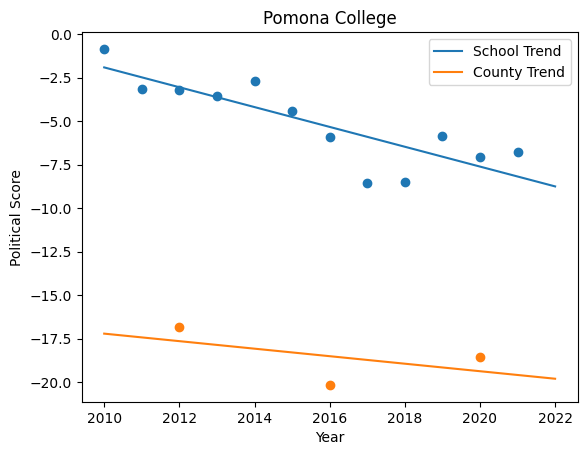

Utah [32.95509616934734, 15.647426004047059, 17.24099409448819]


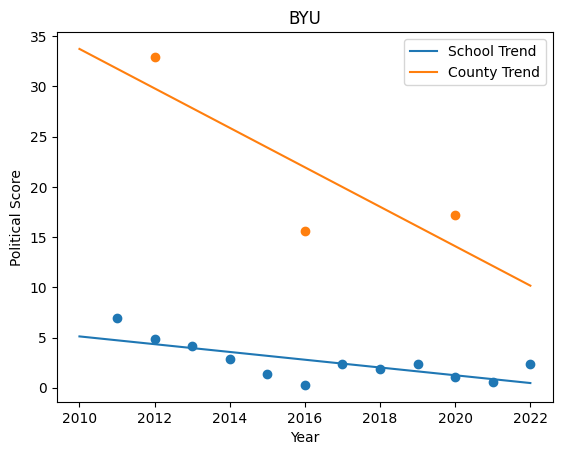

Middlesex [-6.703128932136567, -3.068686228818354, -8.956030438861669]


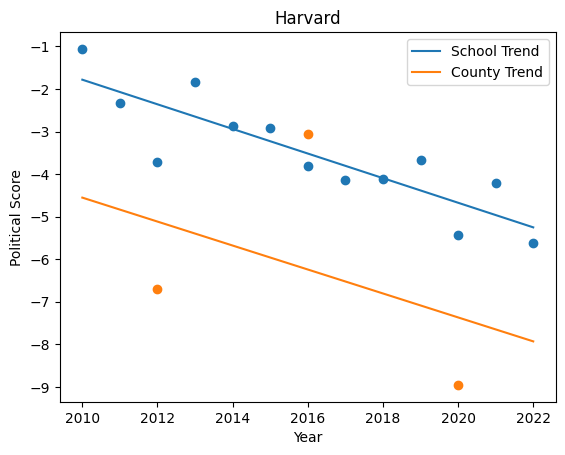

Delaware [0.10361471629303942, 12.519803600654667, -4.179542029970047]


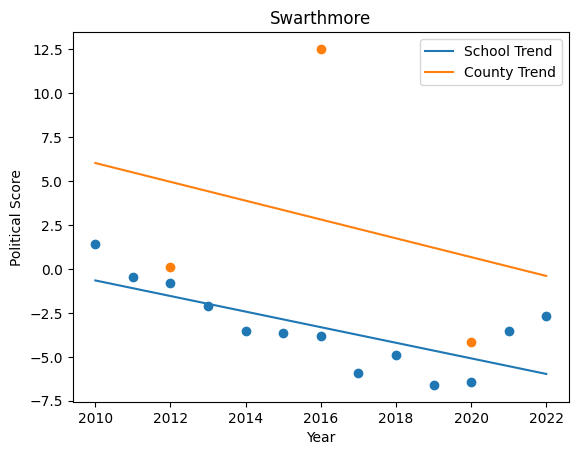

Norfolk [-6.7446822484615705, -11.734094320268545, -9.596360419562748]


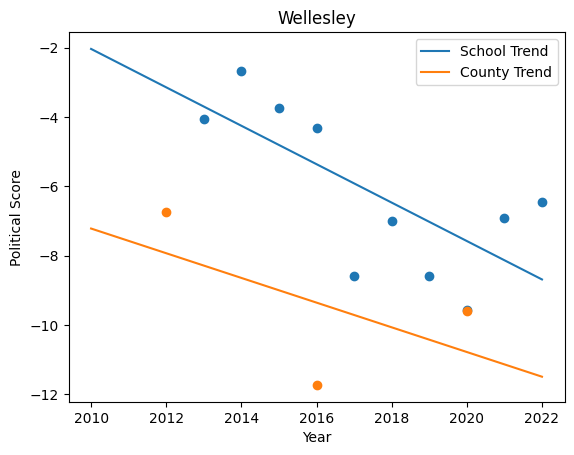

Grafton [-10.007136265764382, -7.969639468690705, -10.578073089700997]


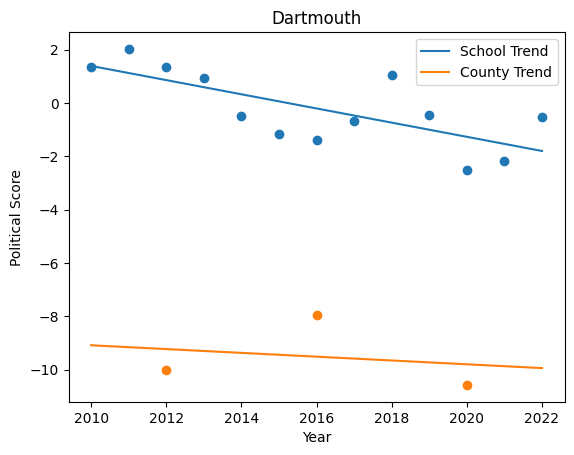

New York [-29.243938560487454, -32.42470339957522, -31.28299650635803]


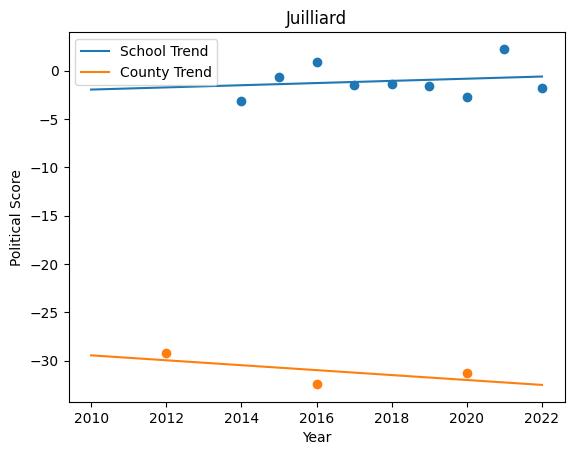

Providence [-14.654392290210687, -8.905838275066376, -26.268826420837204]


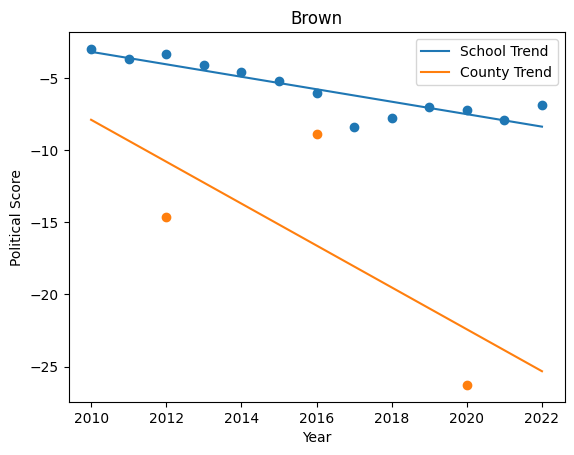

Middlesex [-6.703128932136567, -3.068686228818354, -8.956030438861669]


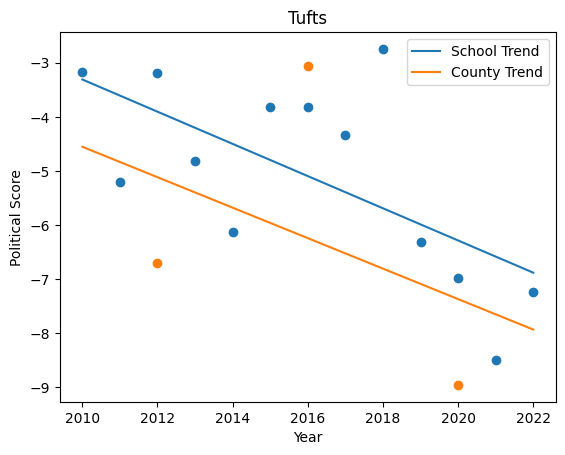

Middlesex [-6.703128932136567, -3.068686228818354, -8.956030438861669]


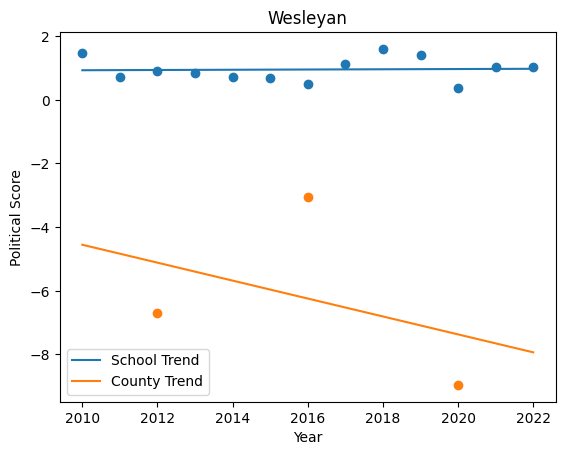

Addison [-16.65594350725775, -14.133697135061391, 3.997461928934012]


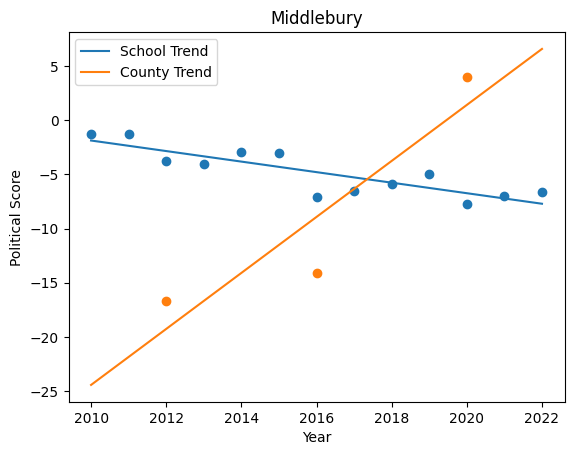

New York [-29.243938560487454, -32.42470339957522, -31.28299650635803]


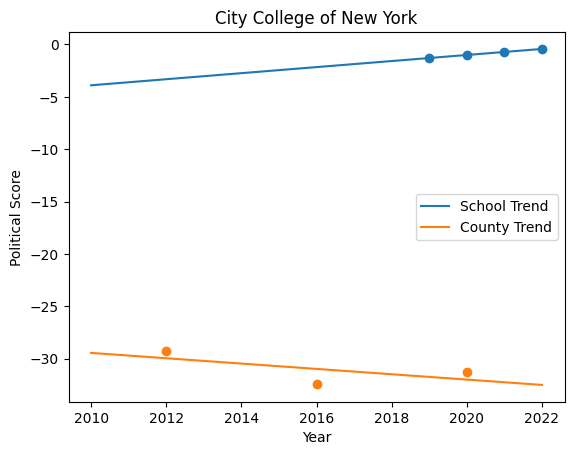

Orange [3.4755486798881847, -3.2256188903010297, -5.019320378585558]


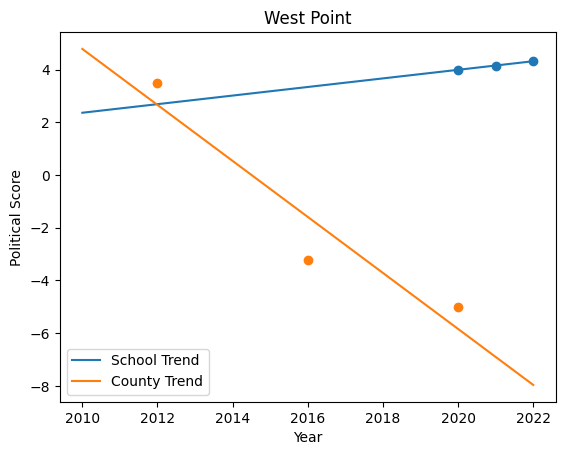

Hampton [-11.451219512195124, -8.023652490334323, -4.547161213888636]


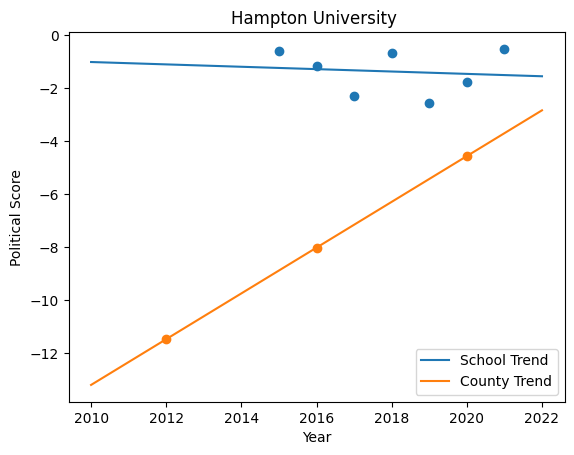

Harris [19.13456941662898, 20.11090775988287, -5.277814607218528]


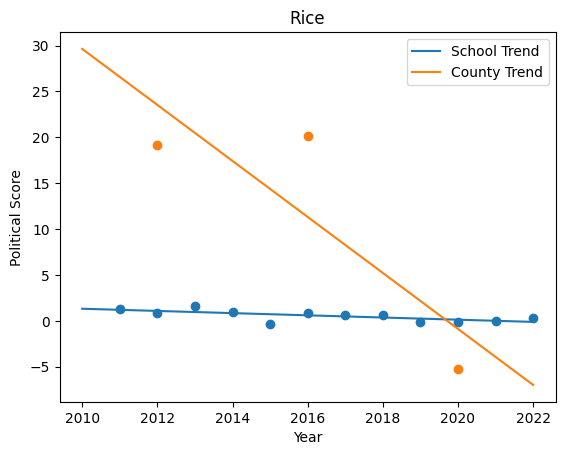

Fulton [13.904024767801863, 21.274451939291737, -14.364568551155871]


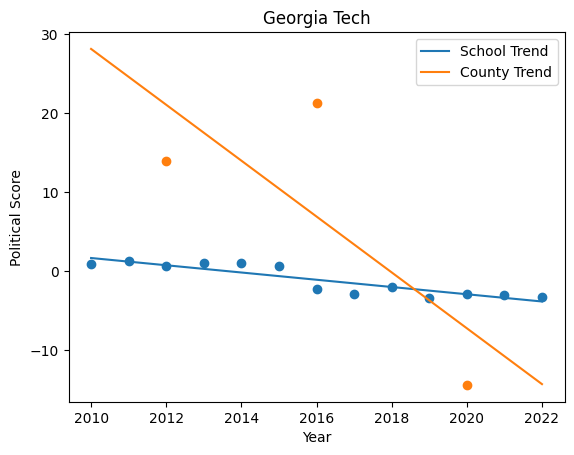

Orange [3.4755486798881847, -3.2256188903010297, -5.019320378585558]


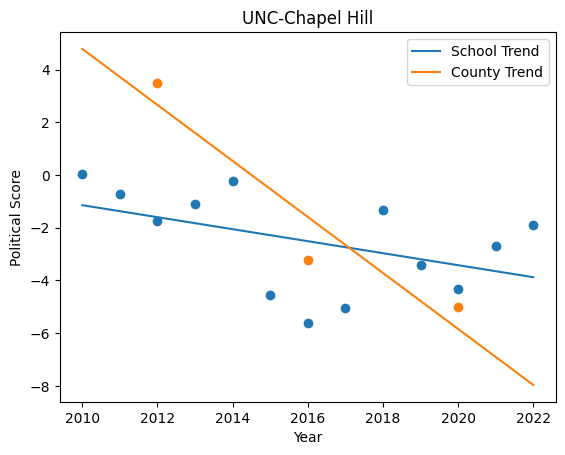

Durham [-22.15200100119587, -25.361312050377634, -25.064599377355403]


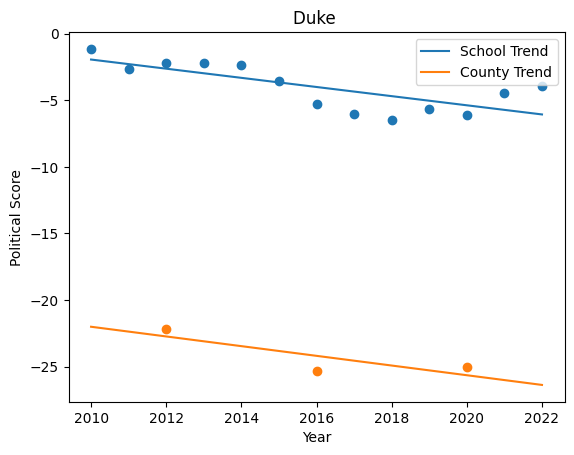

Davidson [17.187873246278254, 20.729090580867343, -6.0613152105120385]


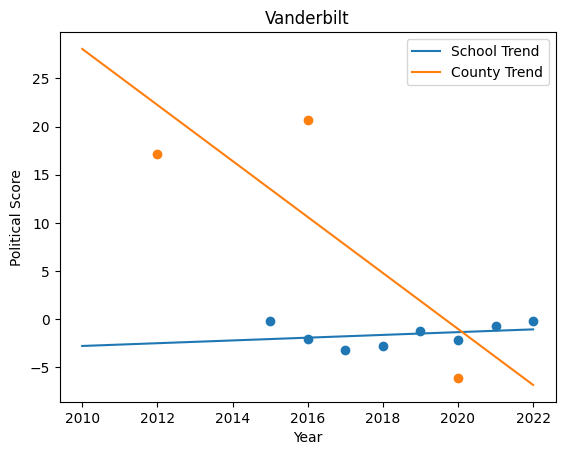

Albemarle [-5.040906722251176, -10.5235686036983, -14.071237453021327]


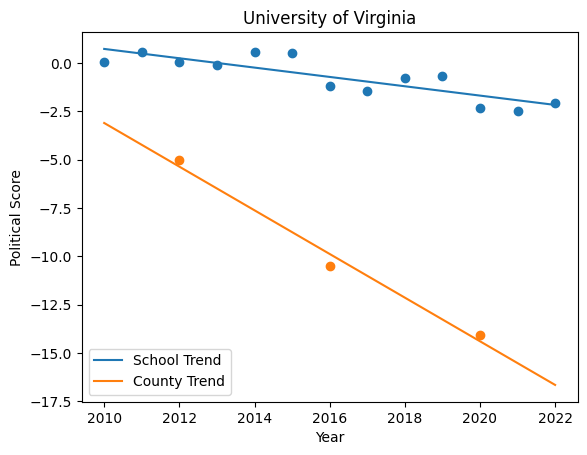

Cook [13.184668989547037, 16.854256376283537, -21.00064830377663]


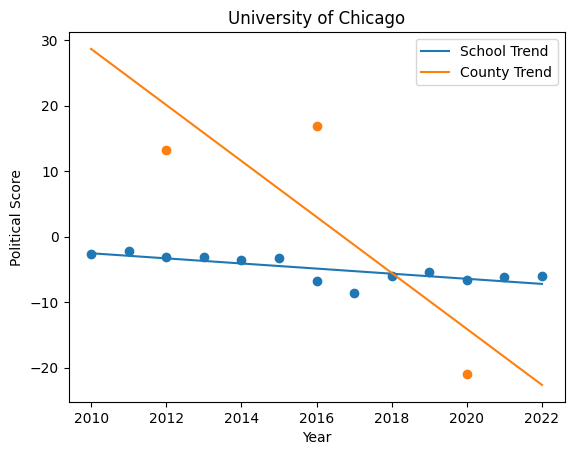

Cook [13.184668989547037, 16.854256376283537, -21.00064830377663]


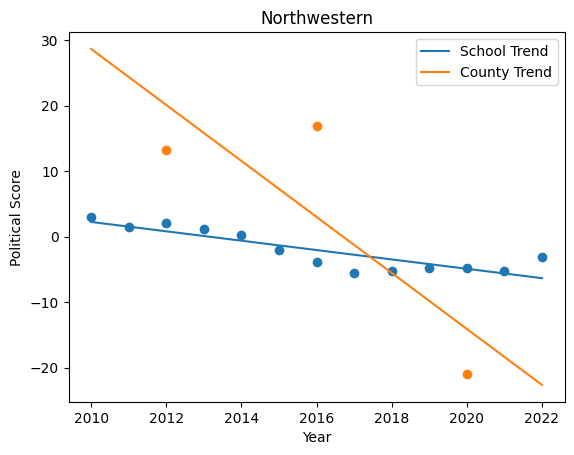

Jackson [17.582583313062518, 26.228530190040896, 3.371724865454417]


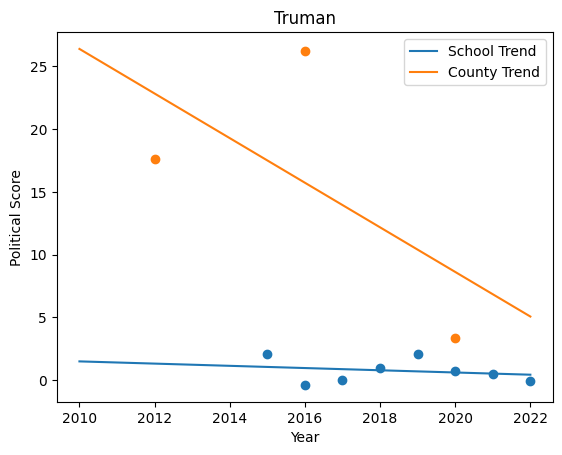

Poweshiek [-3.8259281801582476, 2.877127824203032, 5.5958579881656805]


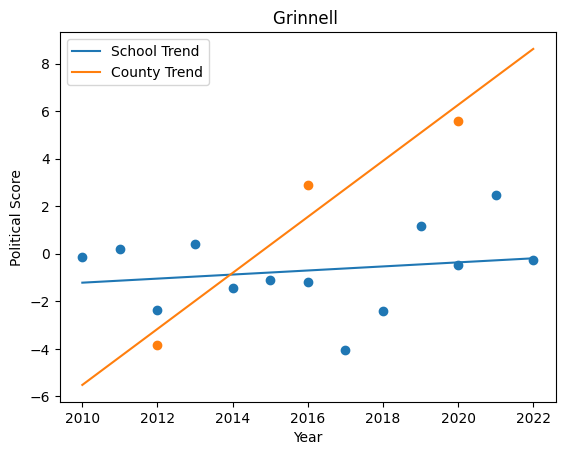

Knox [-7.199893413865084, 1.3748861773811725, 9.35543369890329]


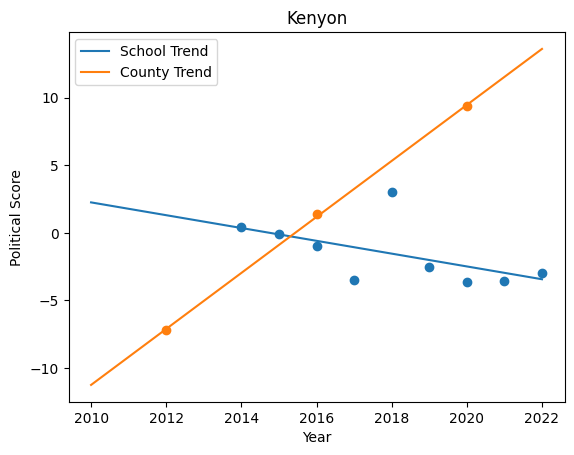

McLean [4.645884875474189, 0.6183429330970327, 0.9009794589947513]


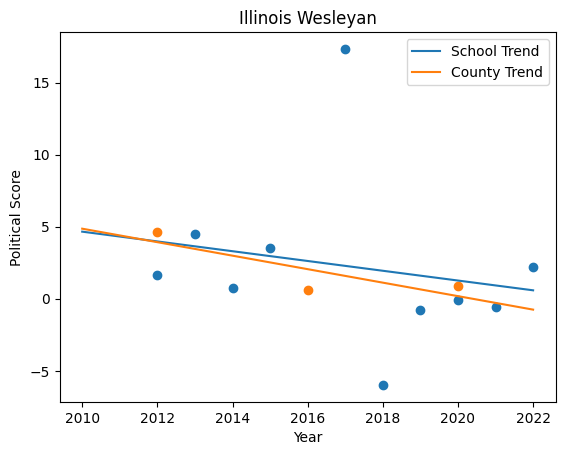

Washoe [-1.4953696025508667, -0.5023174472720994, -1.8935996382990563]


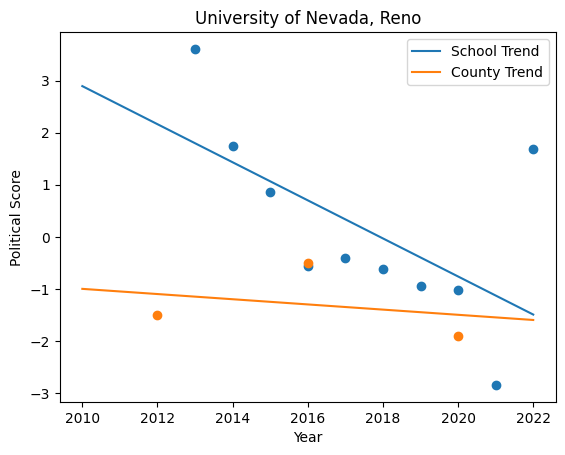

Champaign [-2.8634887915485705, -7.750100901385714, -4.454820841267095]


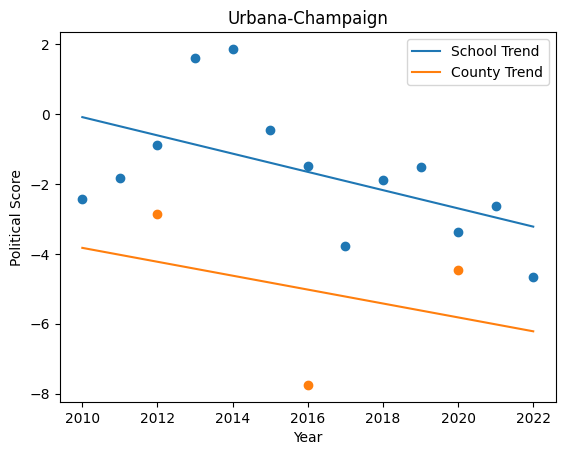

Hennepin [-11.392995213617226, -14.830474961495234, -18.147966384864986]


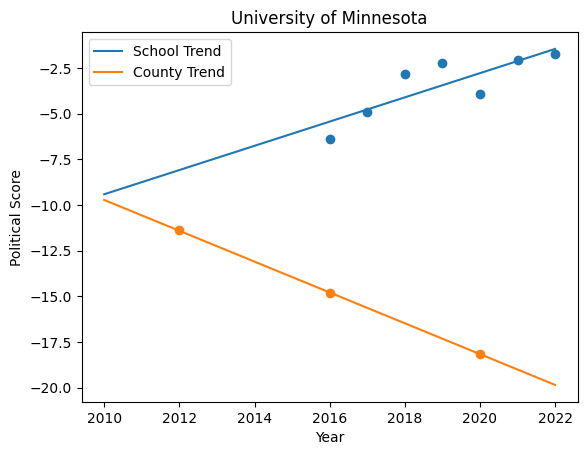

In [69]:
for index, rows in college_data.iterrows():
    if index == 0:
        continue
    
    biprt_x = []
    biprt_lst = []
    for year in range(2010, 2023):
        if pd.isna(rows[str(year)]):
            continue
        else:
            biprt_x.append(year)
            biprt_lst.append(rows[str(year)])
    
    if len(biprt_lst) < 3:
        continue
    
    schl = LinearRegression()
    schl.fit(np.expand_dims(np.array(biprt_x), axis=1), np.expand_dims(np.array(biprt_lst), axis=1))
    pred_line = [schl.predict(np.expand_dims(np.array([i]), axis=1))[0] for i in range(2010, 2023)]
    
    elec_years = [2012, 2016, 2020]
    info = [pt * 42 for pt in get_county_info(rows['County'])]
    
    print(rows['County'], info)
    
    us = LinearRegression()
    us.fit(np.expand_dims(np.array(elec_years), axis=1), np.expand_dims(np.array(info), axis=1))
    pred_elec = [us.predict(np.expand_dims(np.array([i]), axis=1))[0] for i in range(2010, 2023)]
    
    plt.Figure()
    plt.scatter(biprt_x, biprt_lst)
    plt.plot(range(2010, 2023), pred_line, label='School Trend')
    plt.scatter(elec_years, info)
    plt.plot(range(2010, 2023), pred_elec, label='County Trend')
    plt.legend()
    plt.title(rows['Name'])
    plt.xlabel('Year')
    plt.ylabel('Political Score')
    plt.show()

# Undergrad Size vs Polarity

In [37]:
college_data

,,Name,Public / Private,Annual Tuition (2023),Undergraduate Population (2023),Acceptance rate (2021),Ranking (top 100 or not),Geographic location,Male : Female (ratio),Type of College,...,2018,2019,2020,2021,2022,Bipartisan Slope,Bipartisan y-intercept,Ownership,County,School Size
0,region,name,publicprivate,tuition,population,acceptance,ranking,geo,male2female,college-type,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ownership,County,School Size
1,us-west,Stanford,Private,"$57,692","7,761",4.34%,6,Suburban,49 : 51,Research,...,-6.244466,-5.684776,-7.151565,-6.981125,-5.677183,-1.537808,NaN,Independent,Santa Clara,7645
2,us-west,UC Berkeley,Public,"$43,980","32,143",17.50%,49,Urban,46 : 54,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Alameda,"31,814"
3,us-west,Santa Clara,Private,"$58,017","5,895",52.00%,NaN,Suburban,53 : 47,Catholic,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Santa Clara,5895
4,us-west,Caltech,Private,"$58,479",901,6.70%,2,Suburban,65 : 35,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Los Angeles,NaN
5,us-west,USC,Private,"$63,468","20,790",21.10%,43,Urban,46 : 54,Research,...,-3.919732,-2.692837,-5.143249,-2.996033,-0.472082,-0.225776,452.264168,Independent,Los Angeles,NaN
6,us-west,University of Washington,Public,"$40,740","30,856",53.50%,NaN,Urban,45 : 55,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,King,NaN
7,us-west,Harvey Mudd College,Private,"$62,516",905,10%,28,Suburban,50 : 50,Science & Engineering,...,NaN,NaN,0.761180,0.151384,0.425327,NaN,NaN,Independent,Los Angeles,NaN
8,us-west,Pomona College,Private,"$59,238","1,764",6.60%,16,Suburban,45 : 55,Liberal Arts,...,-8.483771,-5.880843,-7.086419,-6.771482,NaN,-0.570280,1144.353493,Independent,Los Angeles,NaN
9,us-west,UCLA,Public,"$13,804","31,600",10.80%,35,Urban,44 : 56,Research,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Independent,Los Angeles,NaN


29


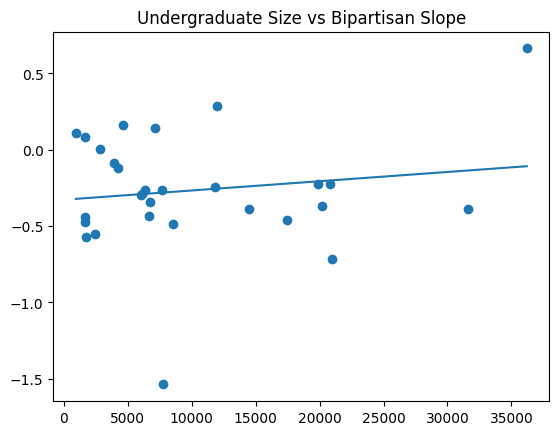

In [67]:
under_sz = []
bip_slp = []

for index, rows in college_data.iterrows():
    if index == 0:
        continue
    
    if not pd.isna(rows['Bipartisan Slope']):
        bip_slp.append(rows['Bipartisan Slope'])
        under_sz.append(int(rows['Undergraduate Population (2023)'].replace(',', '')))

sz_md = LinearRegression()
sz_md.fit(np.array(under_sz).reshape(len(under_sz),-1), np.array(bip_slp).reshape(len(bip_slp), -1))

pred_slp = [sz_md.predict(np.array([sz]).reshape(1,1))[0][0] for sz in np.arange(min(under_sz), max(under_sz)+1, 1)]

print(len(under_sz))

plt.Figure()
plt.plot(np.arange(min(under_sz), max(under_sz)+1, 1), pred_slp)
plt.scatter(under_sz, bip_slp)
plt.title('Undergraduate Size vs Bipartisan Slope')
plt.show()

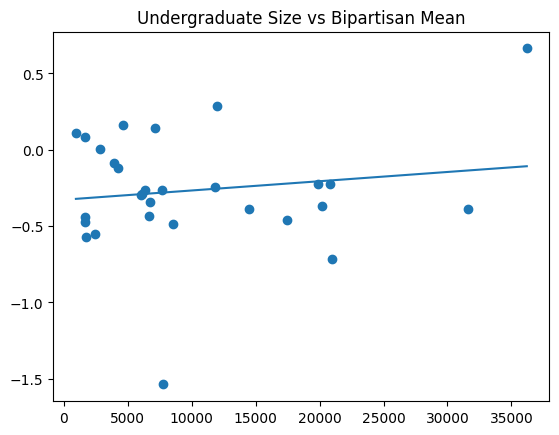

In [66]:
bip_mn = []

for index, rows in college_data.iterrows():
    if index == 0:
        continue
    
    if not pd.isna(rows['Bipartisan Slope']):
        tmp = []
        for yr in range(2018, 2023):
            tmp.append(rows['Bipartisan Slope'])
        
        bip_mn.append(np.mean(tmp))
        
sz_mn = LinearRegression()
sz_mn.fit(np.array(under_sz).reshape(len(under_sz),-1), np.array(bip_mn).reshape(len(bip_mn), -1))

pred_slp = [sz_mn.predict(np.array([sz]).reshape(1,1))[0][0] for sz in np.arange(min(under_sz), max(under_sz)+1, 1)]

# print(pred_slp)

plt.Figure()
plt.plot(np.arange(min(under_sz), max(under_sz)+1, 1), pred_slp)
plt.scatter(under_sz, bip_mn)
plt.title('Undergraduate Size vs Bipartisan Mean')
plt.show()

# Grouping by County

In [73]:
from collections import Counter

In [75]:
county_cnt = Counter(list(college_data['County'])[1:])
county_cnt

Counter({'Los Angeles': 5,
         'Middlesex': 4,
         'Cook': 3,
         'Santa Clara': 2,
         'New York': 2,
         'Orange': 2,
         'Alameda': 1,
         'King': 1,
         'Utah': 1,
         'Delaware': 1,
         'Norfolk': 1,
         'Grafton': 1,
         'Suffolk': 1,
         'Providence': 1,
         'Addison': 1,
         'New Haven': 1,
         'Hampton': 1,
         'Travis': 1,
         'Bedford': 1,
         'DeKalb': 1,
         'Harris': 1,
         'Fulton': 1,
         'Durham': 1,
         'Davidson': 1,
         'Albemarle': 1,
         'Jackson': 1,
         'Poweshiek': 1,
         'Knox': 1,
         'McLean': 1,
         'Washoe': 1,
         'Champaign': 1,
         'Hennepin': 1})

In [77]:
counties = set()

for county, cnt in county_cnt.items():
    if cnt >= 2:
        counties.add(county)
        
counties

{'Cook', 'Los Angeles', 'Middlesex', 'New York', 'Orange', 'Santa Clara'}

In [83]:
def counties_get_school(county):
    return [rows['Name'] for index, rows in college_data.iterrows() if index != 0 and rows['County'] == county]

In [84]:
counties_get_school('Los Angeles')

['Caltech', 'USC', 'Harvey Mudd College', 'Pomona College', 'UCLA']

In [106]:
def get_school_info(schl):
    for index, rows in college_data.iterrows():
        if rows['Name'] == schl:
            bip_yr = []
            bip_val = []
            for yr in range(2010, 2023):
                if not pd.isna(rows[str(yr)]):
                    bip_yr.append(yr)
                    bip_val.append(rows[str(yr)])

            return len(bip_yr) > 0, bip_yr, bip_val
        
    return False, None, None

In [107]:
get_school_info('Stanford')

(True,
 [2010,
  2011,
  2012,
  2013,
  2014,
  2015,
  2016,
  2017,
  2018,
  2019,
  2020,
  2021,
  2022],
 [-0.933991,
  -1.649278,
  -3.162174,
  -3.544305,
  -5.180576,
  -6.166527,
  -6.594643,
  -7.052272,
  -6.244466,
  -5.684776,
  -7.151565,
  -6.981125,
  -5.677183])

In [142]:
def group_counties(county):
    schls = counties_get_school(county)
    
    plt.Figure()
    plt.title(f'{county} County')
    plt.xlabel('Year')
    plt.ylabel('Political Trends')
    for school in schls:
        has, yrs, vals = get_school_info(school)
        if not has:
            continue
        
        schl_reg = LinearRegression()
        schl_reg.fit(np.expand_dims(np.array(yrs), axis=1), np.expand_dims(np.array(vals), axis=1))
        
        plt.scatter(yrs, vals, s=10, alpha=0.5)
        
        pred_rg = np.arange(2010, 2023, 1)
        pred_rs = [schl_reg.predict(np.expand_dims(np.array([x]), axis=1))[0, 0] for x in pred_rg]
        
        plt.plot(pred_rg, pred_rs, label=f'{school} Trend')
    
    elec_years = [2012, 2016, 2020]
    info = [pt * 42 for pt in get_county_info(county)]
    
    us = LinearRegression()
    us.fit(np.expand_dims(np.array(elec_years), axis=1), np.expand_dims(np.array(info), axis=1))
    pred_elec = [us.predict(np.expand_dims(np.array([i]), axis=1))[0] for i in range(2010, 2023)]
    
    plt.scatter(elec_years, info, s=10, alpha=0.5)
    plt.plot(range(2010, 2023), pred_elec, label='County Trend')
    
    plt.legend()
    return plt

<module 'matplotlib.pyplot' from '/home/harry/.local/lib/python3.11/site-packages/matplotlib/pyplot.py'>

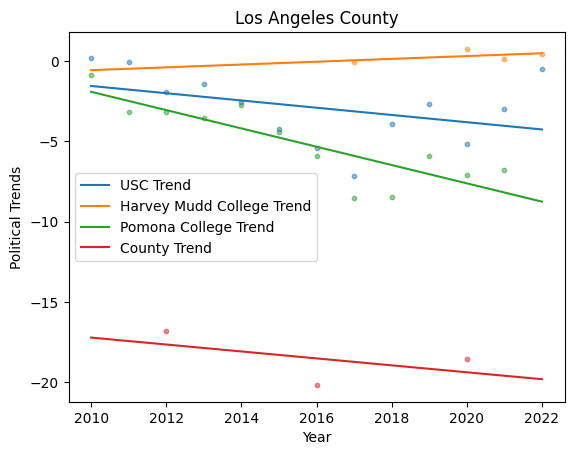

In [143]:
group_counties('Los Angeles')

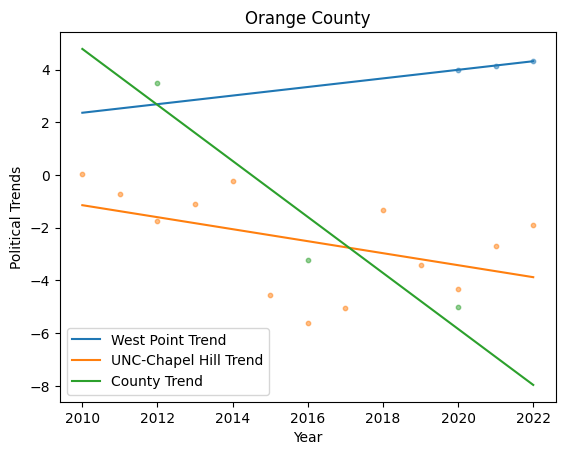

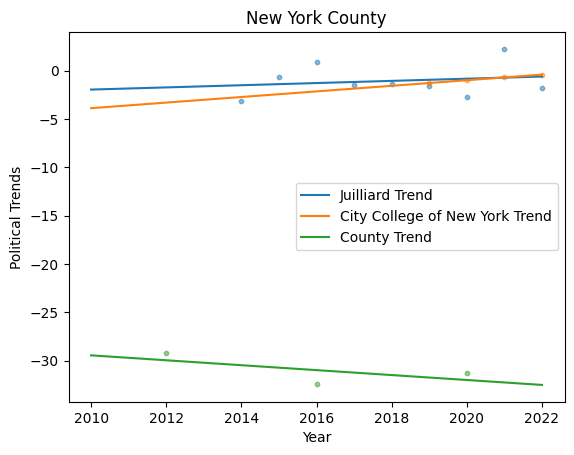

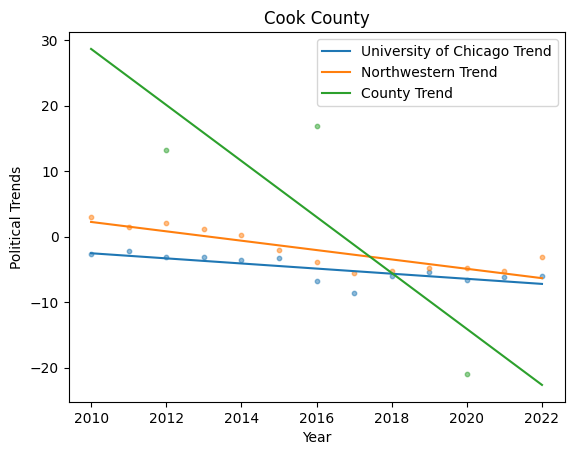

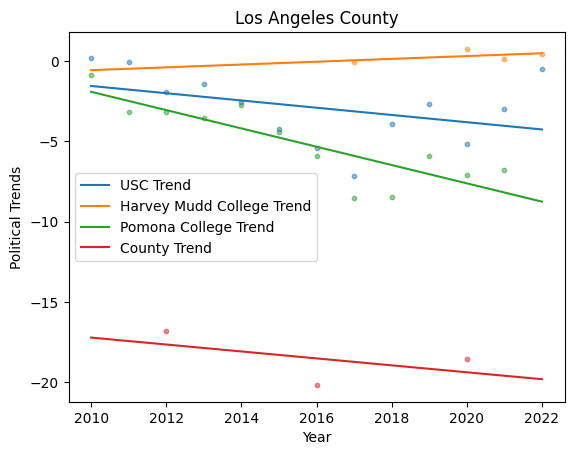

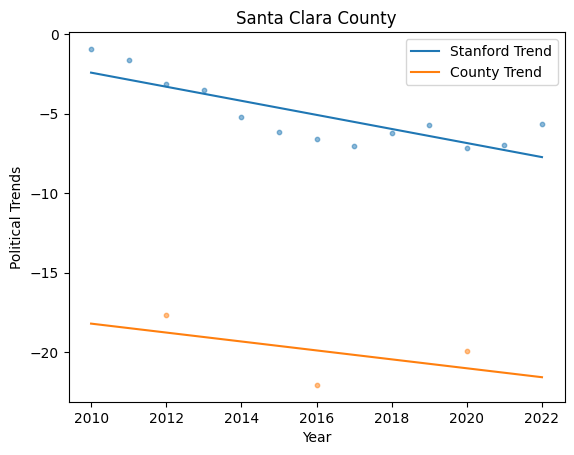

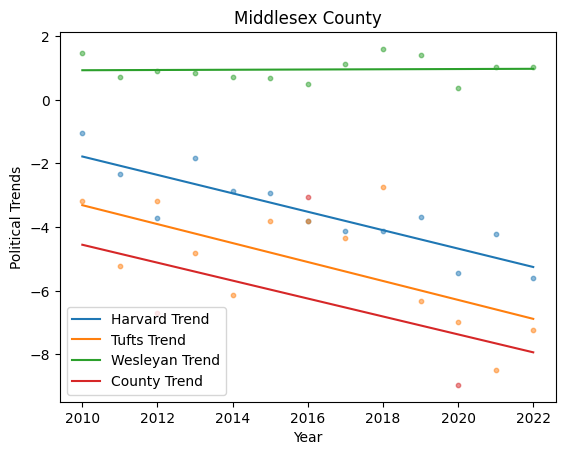

<Figure size 640x480 with 0 Axes>

In [144]:
for county in counties:
    plt = group_counties(county)
    plt.show()
    plt.clf()